In [72]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import normaltest

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Read in Pickle Containing MLB 2017 Data

In order to perform analyses on my data, I need to read in my pickle file:

In [224]:
df = pd.read_pickle('mlb_sal_stats_17.pkl')

In [5]:
df.head()

,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,RA9def,...,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary,Acquired
0,Fernando Abad,31,BOS,43.2,48,0,18,3.71,4.78,0.43,...,2,0.2,.68,-0.2,0.5,7,.504,.501,2000000,Traded
1,Matt Albers,34,WSN,61.0,63,0,12,1.77,4.77,-0.11,...,19,2.0,1.10,-0.1,2.5,25,.531,.512,1150000,Free Agency
2,Raul Alcantara,24,OAK,24.0,8,4,21,7.88,4.80,-0.30,...,-7,-0.7,.12,0.1,-0.4,-4,.416,.496,535000,Traded
3,Cody Allen,28,CLE,67.1,69,0,24,3.21,4.78,0.18,...,9,0.9,1.63,0.1,1.7,17,.513,.506,7350000,Amateur Draft
4,Dan Altavilla,24,SEA,46.2,41,0,27,5.21,5.19,0.08,...,-4,-0.4,.73,-0.1,0.0,2,.491,.498,536100,Amateur Draft


In [6]:
df.columns

Index(['Name', 'Age', 'Tm', 'IP', 'G', 'GS', 'R', 'RA9', 'RA9opp', 'RA9def',
       'RA9role', 'PPFp', 'RA9avg', 'RAA', 'WAA', 'gmLI', 'WAAadj', 'WAR',
       'RAR', 'waaWL%', '162WL%', 'Salary', 'Acquired'],
      dtype='object')

Now that I have my data, I want to convert the columns containing numbers from objects to numerical values.

In [228]:
df[['Age', 'IP', 'G', 'GS', 'R', 'RA9', 'RA9opp',
       'RA9def', 'RA9role', 'PPFp', 'RA9avg', 'RAA', 'WAA', 'gmLI', 'WAAadj',
       'WAR', 'RAR', 'waaWL%', '162WL%', 'Salary']]\
 = df[['Age', 'IP', 'G', 'GS', 'R', 'RA9', 'RA9opp',
       'RA9def', 'RA9role', 'PPFp', 'RA9avg', 'RAA', 'WAA', 'gmLI', 'WAAadj',
       'WAR', 'RAR', 'waaWL%', '162WL%', 'Salary']].apply(pd.to_numeric)

In [8]:
df.dtypes

Name         object
Age           int64
Tm           object
IP          float64
G             int64
GS            int64
R             int64
RA9         float64
RA9opp      float64
RA9def      float64
RA9role     float64
PPFp        float64
RA9avg      float64
RAA           int64
WAA         float64
gmLI        float64
WAAadj      float64
WAR         float64
RAR           int64
waaWL%      float64
162WL%      float64
Salary        int64
Acquired     object
dtype: object

Great! Now I have a dataframe with which I can model my target Salary using linear regression.

# Eliminating Outliers or: Focusing on Starting Pitchers

In [9]:
df.IP.min()

0.10000000000000001

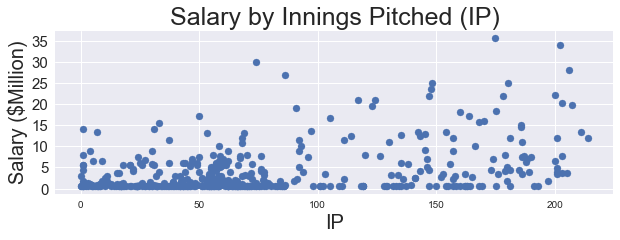

In [226]:
plt.figure(figsize=(10,3))
plt.scatter(df.IP,df.Salary)
plt.xlabel('IP', size=20)
plt.ylabel('Salary ($Million)', size=20)
plt.yticks(np.arange(40000000,step=5000000),(0,5,10,15,20,25,30,35), size=15)
plt.title('Salary by Innings Pitched (IP)', size=25);

Hmmmmmm, it looks like we have some players that did not even pitch a full inning. This could mean that pitchers were injured, underutilized, **OR** that position players (non-pitchers) are occasionally pitching and could skew the data. 

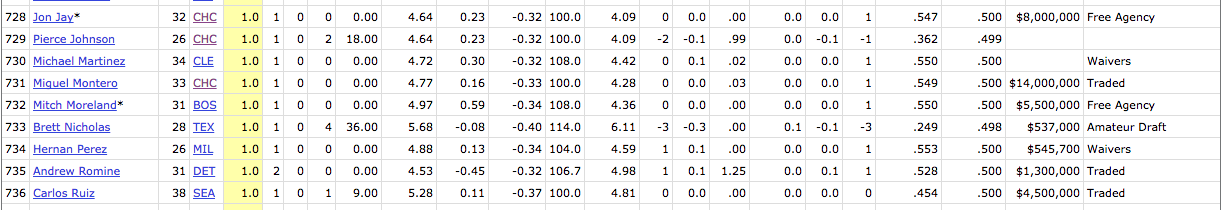

Sure enough, there are players like Jon Jay and Miguel Montero who are position players with high salaries that only pitched for 1 inning. This will obviously skew our data, as we are only interested in pitchers. For this reason, I will remove observations with 4 innings pitched or fewer.

In [11]:
len(df.loc[(df.IP <= 4)])

20

Removing those pitchers that have not pitched very much is an improvement, but I am really just interested in starting pitchers. In that case, I can just remove players that did not start a single game. This might include some relievers who filled in for starters and will certainly include starting pitchers who were injured during the season, but it is an improvement.

In [229]:
df = df.loc[df.GS >= 4]

In [238]:
len(df)

182

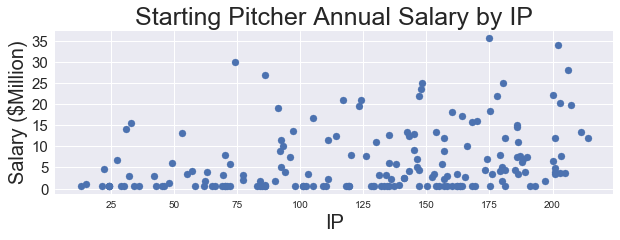

In [230]:
plt.figure(figsize=(10,3))
plt.scatter(df.IP,df.Salary)
plt.xlabel('IP', size=20)
plt.ylabel('Salary ($Million)', size=20)
plt.yticks(np.arange(40000000,step=5000000),(0,5,10,15,20,25,30,35), size=15)
plt.title('Starting Pitcher Annual Salary by IP', size=25);

# Visualize Correlation

I can examine potential correlations using scatter plots through Matplotlib and Pandas.

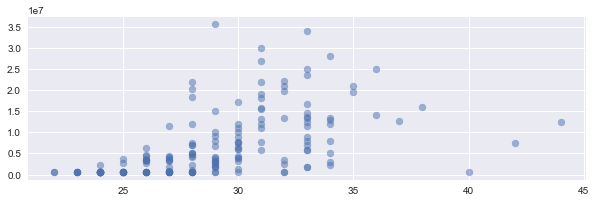

In [15]:
plt.figure(figsize=(10,3))
plt.scatter(df.Age,df.Salary, alpha=.5);

In [16]:
df.corr()

,Age,IP,G,GS,R,RA9,RA9opp,RA9def,RA9role,PPFp,RA9avg,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary
Age,1.000000,0.132370,0.098668,0.148078,0.199850,0.055289,0.002835,0.112072,0.119321,-0.073037,-0.094635,-0.107206,-0.088901,0.098066,-0.010885,-0.043926,-0.047919,-0.094007,-0.073805,0.558753
IP,0.132370,1.000000,0.839239,0.974446,0.826677,-0.504953,-0.146080,-0.008581,0.319721,0.076454,0.053050,0.458735,0.458321,0.099267,-0.610411,0.633257,0.666504,0.477014,0.445310,0.288007
G,0.098668,0.839239,1.000000,0.787603,0.816629,-0.286821,-0.175676,-0.012941,-0.116808,0.086048,-0.022760,0.178105,0.179575,0.196979,-0.586868,0.352845,0.386956,0.258482,0.189184,0.178052
GS,0.148078,0.974446,0.787603,1.000000,0.848898,-0.450796,-0.133052,-0.020559,0.440959,0.053812,0.070832,0.381451,0.378819,0.057260,-0.612403,0.557935,0.594675,0.399794,0.363968,0.268641
R,0.199850,0.826677,0.816629,0.848898,1.000000,-0.021961,-0.105938,-0.164170,0.193480,0.060967,0.134299,-0.089487,-0.086766,0.042938,-0.477945,0.119293,0.160159,-0.023280,-0.092734,0.224471
RA9,0.055289,-0.504953,-0.286821,-0.450796,-0.021961,1.000000,-0.018968,-0.165526,-0.286768,0.051447,0.085347,-0.816203,-0.793910,-0.121127,0.465813,-0.808116,-0.824688,-0.918493,-0.778670,-0.176357
RA9opp,0.002835,-0.146080,-0.175676,-0.133052,-0.105938,-0.018968,1.000000,-0.132638,0.208556,-0.197310,0.399205,0.012065,0.007581,-0.023730,0.013652,-0.014735,-0.006990,0.090729,0.005706,-0.031675
RA9def,0.112072,-0.008581,-0.012941,-0.020559,-0.164170,-0.165526,-0.132638,1.000000,-0.075228,0.052308,-0.639984,0.051292,0.047715,0.235929,-0.059272,0.042355,0.046043,-0.007074,0.046323,0.071909
RA9role,0.119321,0.319721,-0.116808,0.440959,0.193480,-0.286768,0.208556,-0.075228,1.000000,-0.079730,0.243095,0.297432,0.291897,0.025376,-0.259682,0.328159,0.343210,0.254463,0.264216,0.148289
PPFp,-0.073037,0.076454,0.086048,0.053812,0.060967,0.051447,-0.197310,0.052308,-0.079730,1.000000,0.571772,0.207418,0.217301,0.056344,0.096182,0.208281,0.197621,0.157002,0.221856,0.063082


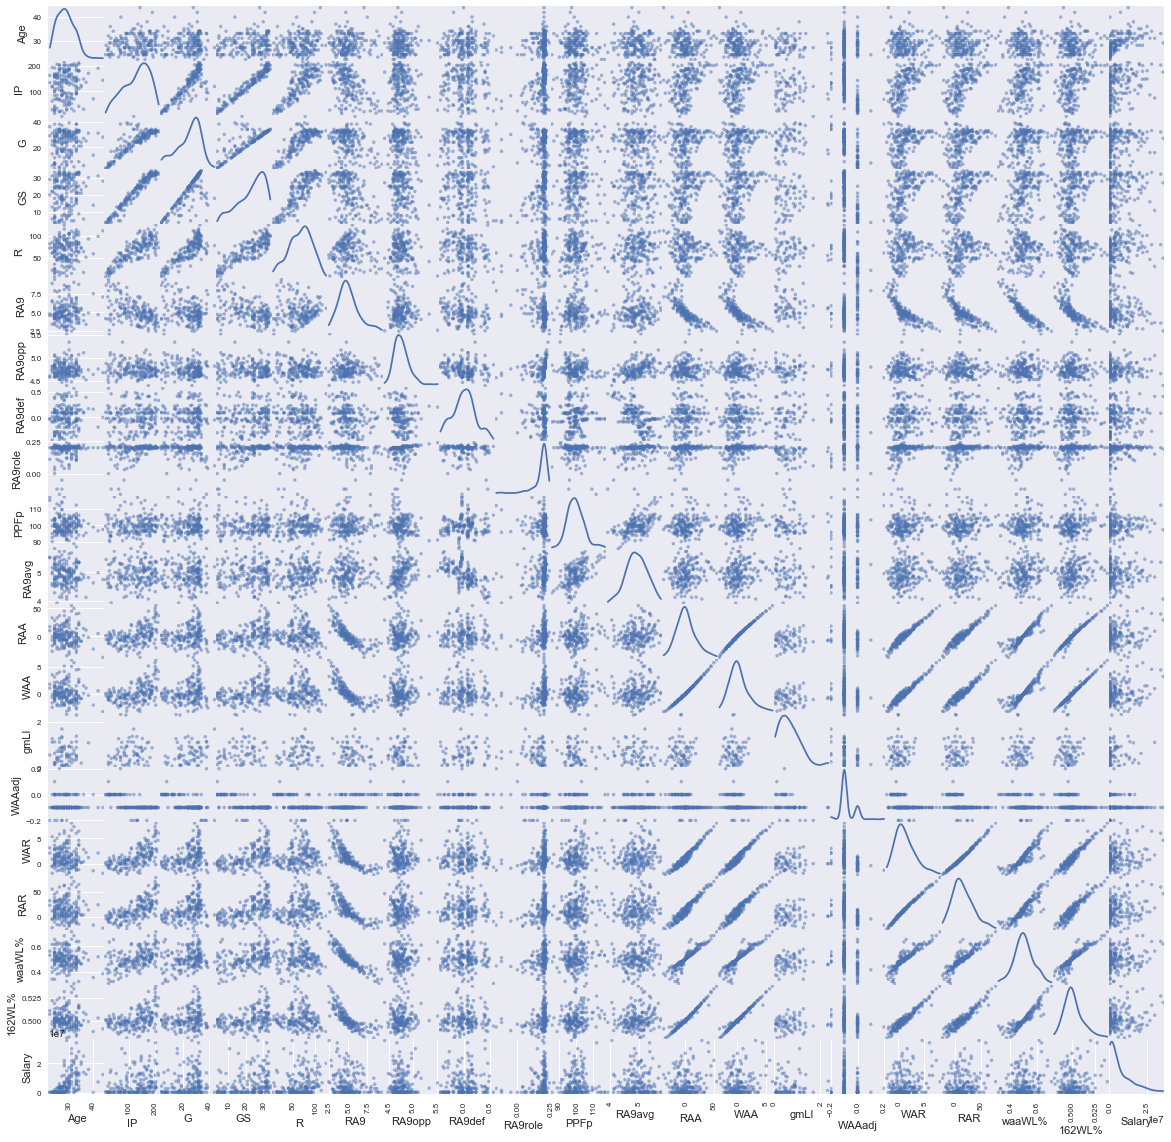

In [17]:
pd.plotting.scatter_matrix(df,figsize=[20, 20], alpha=0.5, diagonal='kde');

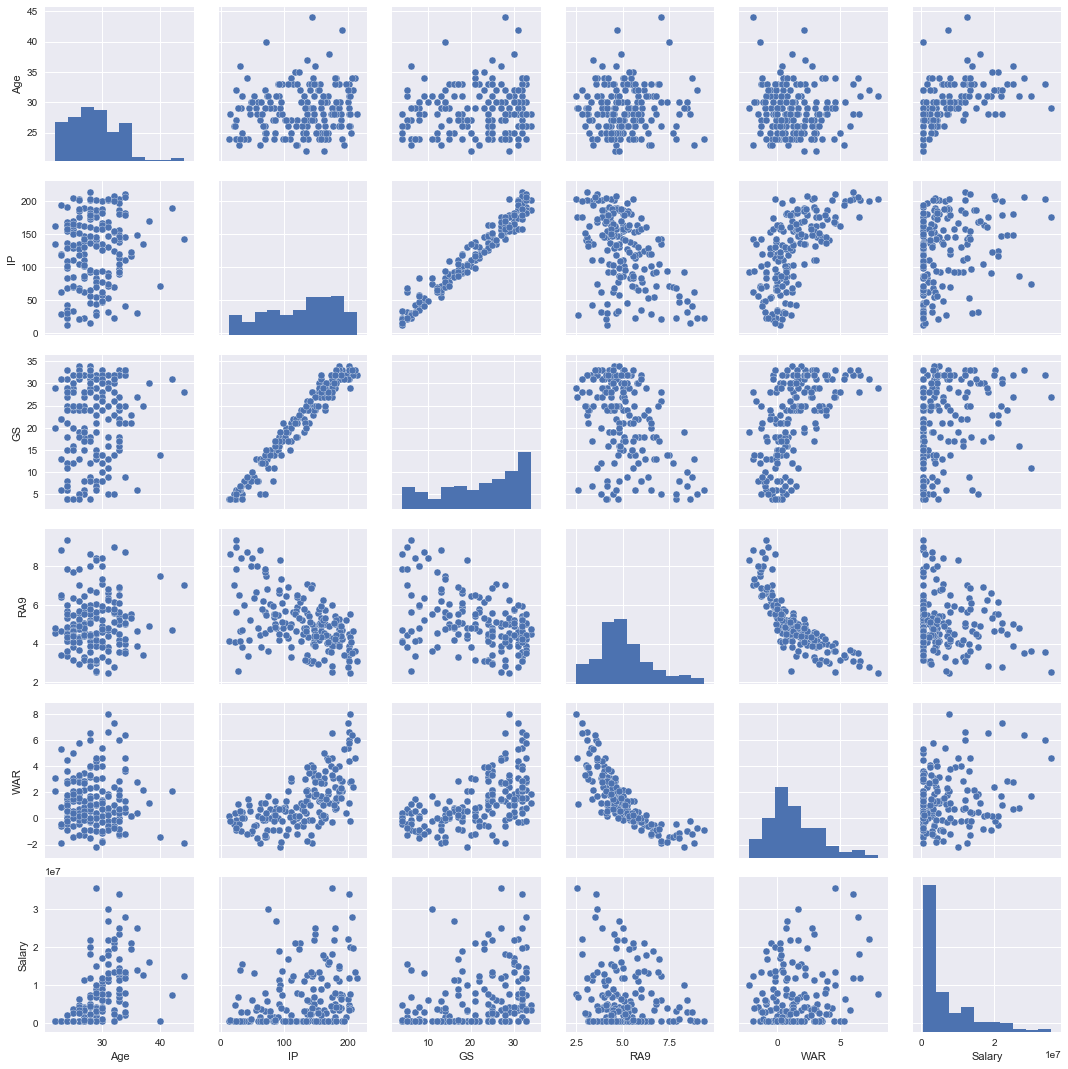

In [242]:
sns.pairplot(df[['Age', 'IP', 'GS', 'RA9', 
       'WAR', 'Salary']]);

Just by looking at the above plots and using my domain knowledge of MLB statistics, I can tell that certain features exhibit colinearity. This is due to the fact that advanced stats are built off of simpler statistics, and are some linear transformation of the original.

# Regression

## MVP: Salary Based on Age

In [122]:
lr_age = LinearRegression()
X = df.loc[:,'Age'].values.reshape(-1,1)
y = df.loc[:,'Salary'].values.reshape(-1,1)
lr_age.fit(X,y)
rmse = np.sqrt(mean_squared_error(y,lr_age.predict(X)))
print('Coefficient Matrix: %s\n Intercept: %s\n R^2: %s\n RMSE: %s'\
      %(lr_age.coef_, lr_age.intercept_, lr_age.score(X,y), rmse))

Coefficient Matrix: [[ 1103499.55124508]]
 Intercept: [-25294882.32614306]
 R^2: 0.312204982507
 RMSE: 6241237.64635


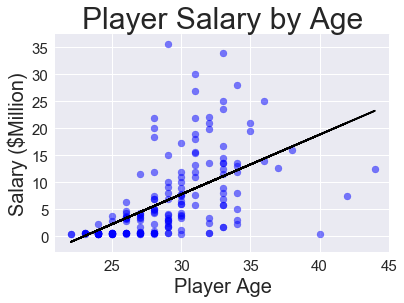

In [19]:
plt.scatter(X, y, c='b', alpha = .5)
plt.plot(X, lr_age.predict(X), c='k')
plt.yticks(np.arange(40000000,step=5000000),(0,5,10,15,20,25,30,35), size=15)
plt.xticks(size=15)
plt.xlabel('Player Age', size=20)
plt.ylabel('Salary ($Million)', size=20)
plt.title('Player Salary by Age', size=30);

In [120]:
lr_age = LinearRegression()
X = df.loc[:,'Age'].values.reshape(-1,1)
y = np.log(df.loc[:,'Salary']).values.reshape(-1,1)
lr_age.fit(X,y)
rmse = np.sqrt(np.exp(mean_squared_error(y,lr_age.predict(X))))
print('Coefficient Matrix: %s\n Intercept: %s\n R^2: %s\n RMSE: %s'\
      %(lr_age.coef_, lr_age.intercept_, lr_age.score(X,y), rmse))

Coefficient Matrix: [[ 0.23993423]]
 Intercept: [ 7.95995608]
 R^2: 0.432100512196
 RMSE: 1.73206084842


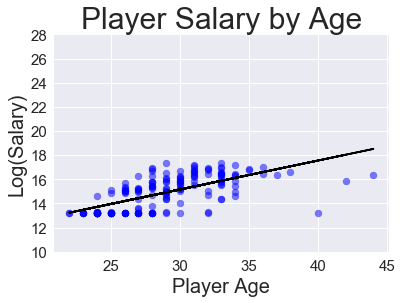

In [21]:
plt.scatter(X, y, c='b', alpha = .5)
plt.plot(X, lr_age.predict(X), c='k')
plt.yticks(np.arange(10,30,step=2),(10,12,14,16,18,20,22,24,26,28,30), size=15)
plt.xticks(size=15)
plt.xlabel('Player Age', size=20)
plt.ylabel('Log(Salary)', size=20)
plt.title('Player Salary by Age', size=30);

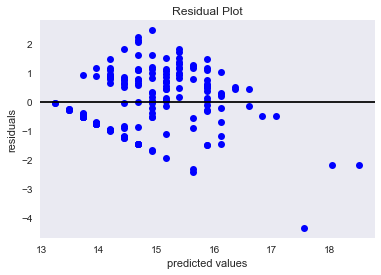

In [22]:
plt.plot(lr_age.predict(X), y-lr_age.predict(X), 'bo')
plt.axhline(y=0, color='k')
plt.grid()
plt.title('Residual Plot')
plt.xlabel('predicted values')
plt.ylabel('residuals');

Transforming Salary to log(Salary) improves the homoskedasticity, although it is by no means perfect.

## Further Linear Regression

Looking at my correlations and scatter matrix from earlier, I can identify a few nice features for my regression. These will be **Age, IP, and WAR**. Many of the features exhibit colinearity, so I chose those features with the highest correlation among their "similar feature groups." 

In [23]:
df_log = df.copy()

df_log.Salary = np.log(df_log.Salary)

In [24]:
df_log.reset_index(inplace=True,drop=True)
df_log.head()

,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,RA9def,...,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary,Acquired
0,Raul Alcantara,24,OAK,24.0,8,4,21,7.88,4.80,-0.30,...,-7,-0.7,0.12,0.1,-0.4,-4,0.416,0.496,13.190022,Traded
1,Brett Anderson,29,2TM,55.1,13,13,41,6.67,4.68,0.05,...,-11,-0.9,NaN,0.0,-0.5,-5,0.428,0.497,15.068274,Free Agency
2,Chase Anderson,29,MIL,141.1,25,25,47,2.99,4.53,0.08,...,27,2.9,NaN,-0.1,4.1,40,0.617,0.518,14.711599,Traded
3,Tyler Anderson,27,COL,86.0,17,15,48,5.02,4.72,-0.03,...,5,0.6,0.84,-0.1,1.3,14,0.533,0.503,13.199324,Amateur Draft
4,Matt Andriese,27,TBR,86.0,18,17,48,5.02,4.75,0.40,...,-7,-0.7,0.08,-0.1,0.1,3,0.463,0.496,13.213118,Traded


In [25]:
df_log.corr()

,Age,IP,G,GS,R,RA9,RA9opp,RA9def,RA9role,PPFp,RA9avg,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary
Age,1.000000,0.132370,0.098668,0.148078,0.199850,0.055289,0.002835,0.112072,0.119321,-0.073037,-0.094635,-0.107206,-0.088901,0.098066,-0.010885,-0.043926,-0.047919,-0.094007,-0.073805,0.657344
IP,0.132370,1.000000,0.839239,0.974446,0.826677,-0.504953,-0.146080,-0.008581,0.319721,0.076454,0.053050,0.458735,0.458321,0.099267,-0.610411,0.633257,0.666504,0.477014,0.445310,0.347662
G,0.098668,0.839239,1.000000,0.787603,0.816629,-0.286821,-0.175676,-0.012941,-0.116808,0.086048,-0.022760,0.178105,0.179575,0.196979,-0.586868,0.352845,0.386956,0.258482,0.189184,0.254322
GS,0.148078,0.974446,0.787603,1.000000,0.848898,-0.450796,-0.133052,-0.020559,0.440959,0.053812,0.070832,0.381451,0.378819,0.057260,-0.612403,0.557935,0.594675,0.399794,0.363968,0.335928
R,0.199850,0.826677,0.816629,0.848898,1.000000,-0.021961,-0.105938,-0.164170,0.193480,0.060967,0.134299,-0.089487,-0.086766,0.042938,-0.477945,0.119293,0.160159,-0.023280,-0.092734,0.316967
RA9,0.055289,-0.504953,-0.286821,-0.450796,-0.021961,1.000000,-0.018968,-0.165526,-0.286768,0.051447,0.085347,-0.816203,-0.793910,-0.121127,0.465813,-0.808116,-0.824688,-0.918493,-0.778670,-0.149615
RA9opp,0.002835,-0.146080,-0.175676,-0.133052,-0.105938,-0.018968,1.000000,-0.132638,0.208556,-0.197310,0.399205,0.012065,0.007581,-0.023730,0.013652,-0.014735,-0.006990,0.090729,0.005706,-0.025934
RA9def,0.112072,-0.008581,-0.012941,-0.020559,-0.164170,-0.165526,-0.132638,1.000000,-0.075228,0.052308,-0.639984,0.051292,0.047715,0.235929,-0.059272,0.042355,0.046043,-0.007074,0.046323,0.112084
RA9role,0.119321,0.319721,-0.116808,0.440959,0.193480,-0.286768,0.208556,-0.075228,1.000000,-0.079730,0.243095,0.297432,0.291897,0.025376,-0.259682,0.328159,0.343210,0.254463,0.264216,0.156552
PPFp,-0.073037,0.076454,0.086048,0.053812,0.060967,0.051447,-0.197310,0.052308,-0.079730,1.000000,0.571772,0.207418,0.217301,0.056344,0.096182,0.208281,0.197621,0.157002,0.221856,0.036797


In [26]:
lr1 = LinearRegression()
X = df_log.loc[:,['Age', 'IP','WAR']]
y = df_log.iloc[:,-2]
lr1.fit(X,y)
rmse = np.sqrt(np.exp(mean_squared_error(y,lr1.predict(X))))
print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(lr1.coef_, lr1.intercept_, rmse))

Coefficient Matrix: [ 0.23107876  0.00546262  0.05913526]
 Intercept: 7.44800823106
 RMSE: 1.61364992227


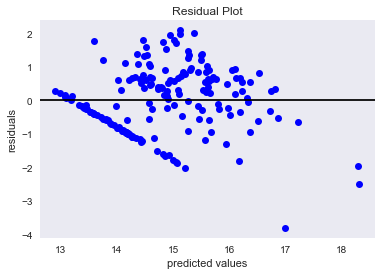

In [27]:
plt.plot(lr1.predict(X), y-lr1.predict(X), 'bo')
plt.axhline(y=0, color='k')
plt.grid()
plt.title('Residual Plot')
plt.xlabel('predicted values')
plt.ylabel('residuals');

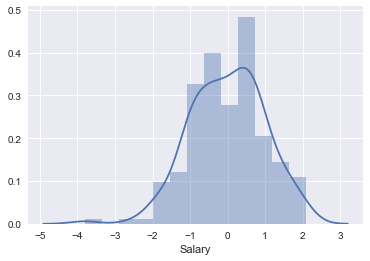

In [28]:
sns.distplot(y-lr1.predict(X));

In [29]:
normaltest(lr1.predict(X))

NormaltestResult(statistic=10.87747836751808, pvalue=0.0043449580123203222)

It looks like the data has some issues conflicting with the underlying assumptions for linear regression. Our residuals appear to not be normally distributed and contain high leverage points. This is not a good sign for the model! But on we go anyway  ¯\_(ツ)_/¯

# Cross-Validation

## KFolds Cross-Validation on Three Features

I have a relatively small dataset - only 182 observations after all the cleaning that was performed. As a result, I will tune my model using cross-validation as opposed to test-train splits. I am going to use the three features included in the linear regression from Section 4.2: Age, Innings Pitched (IP), and WAR.

In [30]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

First, I standardize the features prior to regularization:

In [31]:
s = StandardScaler()
XS = s.fit_transform(X)
XS_std = XS.reshape(182,3)

Now I perform KFolds cross-validation on a lasso punishment term for the regression model:

In [32]:
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

for alpha in alphas:
    train_errors = []
    validation_errors = []
    for train_index, val_index in kf.split(XS_std, y):
        
        # split data
        X_train, X_val = XS_std[train_index], XS_std[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]

        # instantiate model
        lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
        
        #calculate errors
        train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, lasso)
        
        # append to appropriate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    # generate report
    print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(alpha,
                 round(np.mean(np.exp(train_errors)),4),
                 round(np.mean(np.exp(validation_errors)),4)))

alpha:  1e-07 | mean(train_error):  2.5996 | mean(val_error): 2.9349
alpha:  1e-06 | mean(train_error):  2.5996 | mean(val_error): 2.9349
alpha:  1e-05 | mean(train_error):  2.5996 | mean(val_error): 2.9349
alpha: 0.0001 | mean(train_error):  2.5996 | mean(val_error): 2.9348
alpha:  0.001 | mean(train_error):  2.5996 | mean(val_error): 2.934
alpha:   0.01 | mean(train_error):  2.6002 | mean(val_error): 2.9268
alpha:    0.1 | mean(train_error):  2.6555 | mean(val_error): 2.9145
alpha:      1 | mean(train_error):  6.9193 | mean(val_error): 7.728
alpha:   10.0 | mean(train_error):  6.9193 | mean(val_error): 7.728
alpha:  100.0 | mean(train_error):  6.9193 | mean(val_error): 7.728


Based on the KFold test, we should set alpha = .01. This value creates the smallest delta between the mean train and valuation errors. 

## Let's Try Removing a Feature

Now that I have completed an RMSE on Age and a KFold test on three features, I want to check whether removing a feature could improve the model. I cannot really add any features, because the remainder in the dataset are either not reflective of the specific pitcher or display too much colinearity with one of the three features I have already included.

In [189]:
lr2 = LinearRegression()
X2 = df_log.loc[:,['Age', 'IP']]
y2 = df_log.iloc[:,-2]
lr2.fit(X2,y2)
rmse = np.sqrt(np.exp(mean_squared_error(y2,lr2.predict(X2))))
print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(lr2.coef_, lr2.intercept_, rmse))

Coefficient Matrix: [ 0.22711615  0.00686869]
 Intercept: 7.46295410004
 RMSE: 1.61999878281


In [190]:
s = StandardScaler()
XS2 = s.fit_transform(X2)
XS2_std = XS2.reshape(182,2)

In [35]:
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

for alpha in alphas:
    train_errors = []
    validation_errors = []
    for train_index, val_index in kf.split(XS2_std, y2):
        
        # split data
        X_train, X_val = XS2_std[train_index], XS2_std[val_index]
        y_train, y_val = y2.loc[train_index], y2.loc[val_index]

        # instantiate model
        lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
        
        #calculate errors
        train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, lasso)
        
        # append to appropriate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    # generate report
    print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(alpha,
                 round(np.mean(np.exp(train_errors)),4),
                 round(np.mean(np.exp(validation_errors)),4)))

alpha:  1e-07 | mean(train_error):  2.6219 | mean(val_error): 2.885
alpha:  1e-06 | mean(train_error):  2.6219 | mean(val_error): 2.885
alpha:  1e-05 | mean(train_error):  2.6219 | mean(val_error): 2.885
alpha: 0.0001 | mean(train_error):  2.6219 | mean(val_error): 2.885
alpha:  0.001 | mean(train_error):  2.6219 | mean(val_error): 2.8844
alpha:   0.01 | mean(train_error):  2.6224 | mean(val_error): 2.8794
alpha:    0.1 | mean(train_error):  2.6688 | mean(val_error): 2.8901
alpha:      1 | mean(train_error):  6.9193 | mean(val_error): 7.728
alpha:   10.0 | mean(train_error):  6.9193 | mean(val_error): 7.728
alpha:  100.0 | mean(train_error):  6.9193 | mean(val_error): 7.728


That actually improved things! What if I remove IP instead of WAR?

In [48]:
lr3 = LinearRegression()
X3 = df_log.loc[:,['Age', 'WAR']]
y3 = df_log.iloc[:,-2]
lr3.fit(X3,y3)
rmse = np.sqrt(np.exp(mean_squared_error(y3,lr3.predict(X3))))
print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(lr3.coef_, lr3.intercept_, rmse))

Coefficient Matrix: [ 0.24343895  0.15482245]
 Intercept: 7.6544592783
 RMSE: 1.65397852837


In [37]:
s = StandardScaler()
XS3 = s.fit_transform(X3)
XS3_std = XS3.reshape(182,2)

In [38]:
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

for alpha in alphas:
    train_errors = []
    validation_errors = []
    for train_index, val_index in kf.split(XS3_std, y3):
        
        # split data
        X_train, X_val = XS3_std[train_index], XS3_std[val_index]
        y_train, y_val = y3.loc[train_index], y3.loc[val_index]

        # instantiate model
        lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
        
        #calculate errors
        train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, lasso)
        
        # append to appropriate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    # generate report
    print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(alpha,
                 round(np.mean(np.exp(train_errors)),4),
                 round(np.mean(np.exp(validation_errors)),4)))

alpha:  1e-07 | mean(train_error):   2.734 | mean(val_error): 3.0627
alpha:  1e-06 | mean(train_error):   2.734 | mean(val_error): 3.0627
alpha:  1e-05 | mean(train_error):   2.734 | mean(val_error): 3.0627
alpha: 0.0001 | mean(train_error):   2.734 | mean(val_error): 3.0626
alpha:  0.001 | mean(train_error):   2.734 | mean(val_error): 3.0617
alpha:   0.01 | mean(train_error):  2.7346 | mean(val_error): 3.0533
alpha:    0.1 | mean(train_error):  2.7921 | mean(val_error): 3.0606
alpha:      1 | mean(train_error):  6.9193 | mean(val_error): 7.728
alpha:   10.0 | mean(train_error):  6.9193 | mean(val_error): 7.728
alpha:  100.0 | mean(train_error):  6.9193 | mean(val_error): 7.728


Removing IP made my model worse! The results of removing these two features makes sense, as IP and WAR are actually correlated to a certain degree. Based on my additional analyses, the two feature model with Age and IP seems best.

## Model Result

In [59]:
lr2 = LinearRegression()
X2 = df_log.loc[:,['Age', 'IP']]
y2 = df_log.iloc[:,-2]
lr2.fit(X2,y2)
rmse = np.sqrt(np.exp(mean_squared_error(y2,lr2.predict(X2))))
print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(lr2.coef_, lr2.intercept_, rmse))

Coefficient Matrix: [ 0.22711615  0.00686869]
 Intercept: 7.46295410004
 RMSE: 1.61999878281


I want to see a plot of my linear model compared to the actual salary values. Fortunately, I am only modeling using two features, so I can create a 3D scatter plot with my hyperplane.

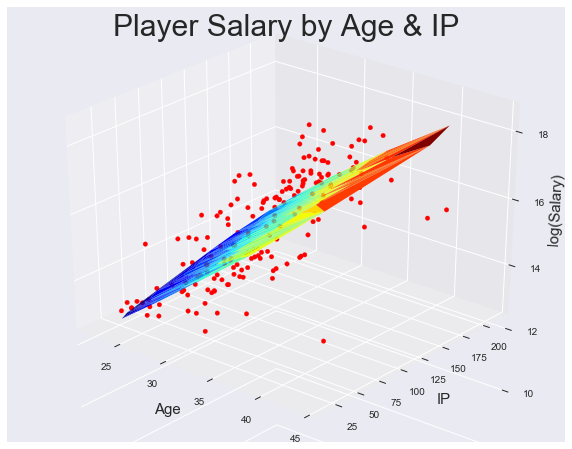

In [231]:
Age = np.array(X2.Age)
IP = np.array(X2.IP)
y2a = np.array(y2)
pred_y = np.array(lr2.predict(X2))

figlm = plt.figure(figsize=(10,8))
ax = figlm.add_subplot(111, projection='3d')
ax.plot_trisurf(Age, IP, pred_y, cmap = cm.jet)
ax.scatter(Age, IP, y2a, c='r', alpha=1)

ax.view_init(elev=30,azim=-50)
ax.set_zticks(np.arange(20,step=2))
# ax.set_xticks(size=15)
# ax.set_yticks(size=15)
ax.set_xlabel('Age', labelpad=10, size=15)
ax.set_ylabel('IP', labelpad=10, size=15)
ax.set_zlabel('log(Salary)', size=15)
ax.set_title('Player Salary by Age & IP', size=30);

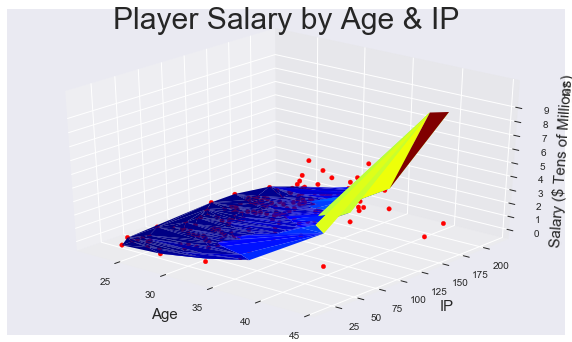

In [236]:
Age = np.array(X2.Age)
IP = np.array(X2.IP)
y2a = np.exp(np.array(y2))
pred_y = np.exp(np.array(lr2.predict(X2)))

figlm = plt.figure(figsize=(10,6))
ax = figlm.add_subplot(111, projection='3d')
ax.plot_trisurf(Age, IP, pred_y, cmap = cm.jet)
ax.scatter(Age, IP, y2a, c='r', alpha=1)

ax.view_init(elev=30,azim=-50)
ax.set_zticks(np.arange(100000000,step=10000000))
# ax.set_xticks(size=15)
# ax.set_yticks(size=15)
ax.set_xlabel('Age', labelpad=10, size=15)
ax.set_ylabel('IP', labelpad=10, size=15)
ax.set_zlabel('Salary ($ Tens of Millions)', size=15)
ax.set_title('Player Salary by Age & IP', size=30);

That's actually a nice looking plot! The shortcomings of my model become really clear with this visualization: young super-star caliber starting pitchers with rich contracts are predicted to have much lower annual salaries than is actually observed. Logically, this makes sense - a few young talented pitchers with shorter rookie contracts are eligible for a large payday before many of their peers. My model heavily weights age in a positive linear fashion, which is misleading. At a certain point, age begins to affect pitchers' ability and teams become less interested in providing large long-term contracts to older players. A better model would have the relationship between age and annual salary look like a positive half-cycle of a sine wave function (see below). Pitchers with more innings pitched receive higher salaries, which does seem to be more fitting of a linear relationship as it demonstrates both durability and dependability, which are typically traits that teams reward with higher salaries (personal insight: teams tend to rely heavily upon their best starting pitchers, especially in the playoffs, leading to higher IP values for talented starting pitchers).

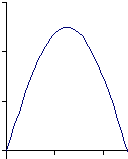

In [53]:
s = StandardScaler()
XS2 = s.fit_transform(X2)
XS2_std = XS2.reshape(182,2)

In [54]:
X_test, y_test = (XS2_std[32],y2.iloc[32])
XS2_std = np.delete(XS2_std,32,axis=0).reshape(181,2)
y2 = y2.drop(y2.index[32])

lass1 = Lasso(alpha=0.001)
lass1.fit(XS2_std,y2)
rmse = np.sqrt(np.exp(mean_squared_error(y2,lass1.predict(XS2_std))))
# Lasso(alpha = .001, fit_intercept=True, random_state=32)
print('Coefficient Matrix: %s\n Intercept: %s\n RSME: %s'%(lass1.coef_,lass1.intercept_,rmse))plt.scatter(X, y, c='b', alpha = .5)

Coefficient Matrix: [ 0.86386178  0.36409712]
 Intercept: 14.8471456707
 RSME: 1.62235736517


Okay, let's predict an annual salary for Yu Darvish, arguably the top free agent starting pitcher in this year's class:

In [55]:
yd_logsal = lass1.predict(X_test.reshape(1,-1))
salary = np.exp(yd_logsal)
salary

array([ 5641694.29705194])

What was Darvish's actual salary in 2017? Well, that information was partitioned off from the model and can be calculated using the cell below:

In [41]:
np.exp(y_test)

11000000.000000015

Looks like the estimate was well below the Darvish's actual salary. 
However, Darvish will be 31 this year - will the age adjustment improve our estimate?

In [56]:
# X_test_31 = X_test.copy()
X_test_31 = s.transform((31,186.2)).reshape(1,-1)
yd_logsal_31 = lass1.predict(X_test_31.reshape(1,-1))
salary = np.exp(yd_logsal_31)
salary

/Users/chrisgillespie/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 7077256.98501336])

There you have it, my model's prediction for Darvish's salary in 2018 using his 2017 IP is **\$7.08 million**.

Yu Darvish made \$11 million in 2017, which is well above both predictions. My favorite website around this time of year, MLBTradeRumors, predicts that Darvish will land a contract worth \$160 million over 6 years - that is an average annual salary of **\$26.67 million**!

# Polynomial Features for Fun

I decided to try polynomial features to adjust for a non-linear relationship just for fun.

In [138]:
poly = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=True))])
poly.fit(X2, y2)
rmse_p = np.sqrt(np.exp(mean_squared_error(y2,poly.predict(X2))))
rmse_p
# print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(poly.coef_,poly.intercept_,rms_p))

1.4215656755043193

Uh oh, it looks like my fun attempt has yielded a significantly lower RMSE...
I am certain at this point that the relationship between my data and target is non-linear.

In [139]:
poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=True))])
poly.fit(X2, y2)
rmse_p = np.sqrt(np.exp(mean_squared_error(y2,poly.predict(X2))))
print(rmse_p)

1.45803118711


I need to run my original regression over again so the X and y reset.

In [166]:
lr2 = LinearRegression()
X2 = df_log.loc[:,['Age', 'IP']]
y2 = df_log.iloc[:,-2]
lr2.fit(X2,y2)
rmse = np.sqrt(np.exp(mean_squared_error(y2,lr2.predict(X2))))
print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(lr2.coef_, lr2.intercept_, rmse))

Coefficient Matrix: [ 0.22711615  0.00686869]
 Intercept: 7.46295410004
 RMSE: 1.61999878281


In [178]:
polyX = PolynomialFeatures(3)
polyX.fit_transform(X2)
lrp = LinearRegression()

lrp.fit(polyX.fit_transform(X2),y2)
rmse_p2 = np.sqrt(np.exp(mean_squared_error(y2,lrp.predict(polyX.fit_transform(X2)))))
rmse_p2
print('Coefficient Matrix: %s\n Intercept: %s\n RMSE: %s'%(lrp.coef_,lrp.intercept_,rmse_p2))

Coefficient Matrix: [  0.00000000e+00   5.70155517e-02  -6.76715277e-02   2.17366495e-02
   1.15289507e-03   4.15906558e-04  -4.98667037e-04   5.63094708e-05
  -1.77993152e-05   3.70512564e-07]
 Intercept: 6.47787475455
 RMSE: 1.45803118711


In [168]:
XP3 = polyX.fit_transform(X2)
s = StandardScaler()
XS = s.fit_transform(XP3)
XS_std = XS.reshape(182,10)
print(polyX.get_feature_names(X2.columns))
# number of features after polynomial tranfsormation

['1', 'Age', 'IP', 'Age^2', 'Age IP', 'IP^2', 'Age^3', 'Age^2 IP', 'Age IP^2', 'IP^3']


In [169]:
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for alpha in alphas:
    train_errors = []
    validation_errors = []
    for train_index, val_index in kf.split(XS_std, y2):
        
        # split data
        X_train, X_val = XS_std[train_index], XS_std[val_index]
        y_train, y_val = y2.loc[train_index], y2.loc[val_index]

        # instantiate model
        lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
        
        #calculate errors
        train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, lasso)
        
        # append to appropriate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    # generate report
    print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(alpha,
                 round(np.mean(train_errors),4),
                 round(np.mean(np.exp(validation_errors)),4)))

alpha:  1e-05 | mean(train_error):  0.7633 | mean(val_error): 2.4462
alpha: 0.0001 | mean(train_error):  0.7637 | mean(val_error): 2.4459
alpha:  0.001 | mean(train_error):  0.7713 | mean(val_error): 2.4602
alpha:   0.01 | mean(train_error):  0.7914 | mean(val_error): 2.4218
alpha:    0.1 | mean(train_error):  0.9665 | mean(val_error): 2.9014
alpha:      1 | mean(train_error):  1.9334 | mean(val_error): 7.728


/Users/chrisgillespie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


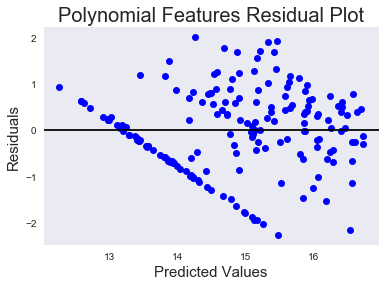

In [248]:
plt.plot(lrp.predict(XP3), y2-lrp.predict(XP3), 'bo')
plt.axhline(y=0, color='k')
plt.grid()
plt.title('Polynomial Features Residual Plot', size=20)
plt.xlabel('Predicted Values',size=15)
plt.ylabel('Residuals',size=15);

From the above train errors and validation errors, I can choose an alpha of .0001 to minimize RMSE. Now, I will train on the training portion of my data and test on the test values of Yu Darvish.

In [170]:
# Break out Darvish's statistics from the dataset as the test case
X_test, y_test = (XS_std[32],y2.iloc[32])
XS2_std_train = np.delete(XS_std,32,axis=0).reshape(181,10)
y_train = y2.drop(y2.index[32])

lass1 = Lasso(alpha=0.0001)
lass1.fit(XS2_std_train,y_train)
rmse = np.sqrt(np.exp(mean_squared_error(y_train,lass1.predict(XS2_std_train))))

print('Coefficient Matrix: %s\n Intercept: %s\n RSME: %s'%(lass1.coef_,lass1.intercept_,rmse))

Coefficient Matrix: [ 0.          3.08763753 -1.02926635 -0.7234677   1.17247672  0.58541808
 -1.99023761  1.12616649 -2.56128987  1.34394974]
 Intercept: 14.8490123465
 RSME: 1.47109406383


/Users/chrisgillespie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [172]:
#Calculate Darvish's predicted salary based on a model
#with two features transformed to polynomial features 
#of the third degree
yd_logsal = lass1.predict(X_test.reshape(1,-1))
salary = np.exp(yd_logsal)
salary

array([ 7924184.57394076])

The model with polynomial features predicts a salary of **\$7.92 million** for Darvish in 2017, which is a pretty marked improvement over the **\$5.64 million** estimate from the base model with two features and log(Salary). However, this is still only 72% of his actual salary in 2017.

# Appendix

In [220]:
from scipy.special import expit

In [221]:
df_sigmoid = df.copy()

df_sigmoid.Salary = expit(df_sigmoid.Salary)

In [222]:
df_sigmoid.reset_index(inplace=True,drop=True)
df_sigmoid.head()

,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,RA9def,...,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary,Acquired
0,Raul Alcantara,24,OAK,24.0,8,4,21,7.88,4.80,-0.30,...,-7,-0.7,0.12,0.1,-0.4,-4,0.416,0.496,1.0,Traded
1,Brett Anderson,29,2TM,55.1,13,13,41,6.67,4.68,0.05,...,-11,-0.9,NaN,0.0,-0.5,-5,0.428,0.497,1.0,Free Agency
2,Chase Anderson,29,MIL,141.1,25,25,47,2.99,4.53,0.08,...,27,2.9,NaN,-0.1,4.1,40,0.617,0.518,1.0,Traded
3,Tyler Anderson,27,COL,86.0,17,15,48,5.02,4.72,-0.03,...,5,0.6,0.84,-0.1,1.3,14,0.533,0.503,1.0,Amateur Draft
4,Matt Andriese,27,TBR,86.0,18,17,48,5.02,4.75,0.40,...,-7,-0.7,0.08,-0.1,0.1,3,0.463,0.496,1.0,Traded


Try to sine transform Salary?

In [176]:
lr_sin = LinearRegression()
X = df.loc[:,'Age'].values.reshape(-1,1)
y = np.sin(df.loc[:,'Salary']).values.reshape(-1,1)
lr_sin.fit(X,y)
rmse = np.sqrt(np.exp(mean_squared_error(y,lr_sin.predict(X))))
print('Coefficient Matrix: %s\n Intercept: %s\n R^2: %s\n RMSE: %s'\
      %(lr_age.coef_, lr_age.intercept_, lr_age.score(X,y), rmse))

Coefficient Matrix: [[ 1103499.55124508]]
 Intercept: [-25294882.32614306]
 R^2: -1.1106837617e+14
 RMSE: 1.30187655469


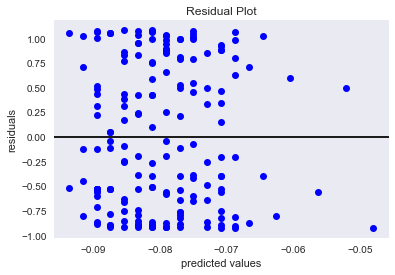

In [177]:
plt.plot(lr_sin.predict(X), y-lr_sin.predict(X), 'bo')
plt.axhline(y=0, color='k')
plt.grid()
plt.title('Residual Plot')
plt.xlabel('predicted values')
plt.ylabel('residuals');